Down Up 87 87 cllsrvpek0035m3b9ujpicnh6
Down Up 78 78 cllsrw0nt003dm3b95su850fe
Down Up 72 72 cllsrw3m1003fm3b9z6jjz7u7
Down Up 84 84 cllsrvmmz0033m3b9c6ynk2e8
Down Up 72 72 cllsrvvg70039m3b99yoz0w5l
Down Up 96 96 cllsrwas2003jm3b9h5zhw7zd
Down Up 78 78 cllsrw6vc003hm3b9oxjemk9w
Down Up 96 96 cllsrwify003nm3b9dza9jrc2
Square 134 134 cllsrbyxa0003m3b9etxojn1j
Square 129 129 cllsrc6ag0007m3b9z9qikjf9
Square 119 119 cllsrccxe000bm3b9oycqq7ho
Square 125 125 cllsrc9o10009m3b9yshf2yna
Square 171 171 cllsrcop5000hm3b9om67plby
Circle 77 77 cllsrdczq000pm3b95ua5nl3d
Square 113 113 cllsrcg8s000dm3b9odrnkaxm
Square 132 132 cllsrck2z000fm3b96blhvlx1
Square 149 149 cllsrcw13000jm3b9lxx9fk7g
Circle 95 95 cllsrda95000nm3b92qs4ktff
Circle 74 74 cllsrdfc5000rm3b98tcbmzpy
Circle 72 72 cllsrdjzn000vm3b9na0rktc1
Circle 71 71 cllsrdres0011m3b9kls2ie9h
Circle 72 72 cllsrdhom000tm3b9vsb3nly3
Circle 66 66 cllsrdooh000zm3b9qhaysqpz
Up Down 78 78 cllsregzp0019m3b91b4il4u8
Up Down 84 84 cllsrg5kb001nm3b90duy4c8f

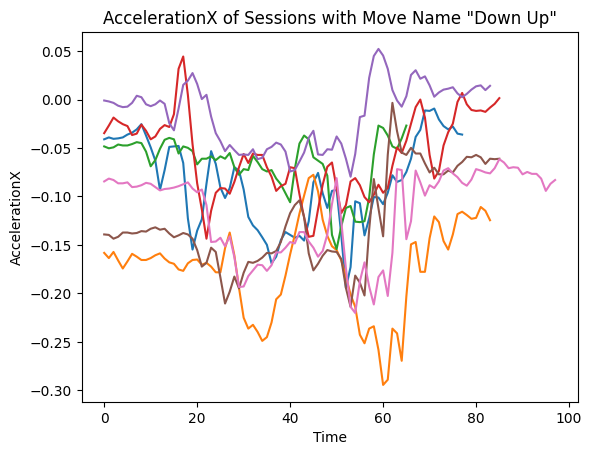

In [3]:
import numpy as np
from dotenv import load_dotenv
import os
import psycopg
import matplotlib.pyplot as plt

load_dotenv()

def get_connection():
  DATABASE_URL = os.getenv('DATABASE_URL')
  CONNECTION_DICT = psycopg.conninfo.conninfo_to_dict(DATABASE_URL)
  conn = psycopg.connect(**CONNECTION_DICT)
  return conn

conn = get_connection()

cur = conn.execute('Select * FROM "Session" LIMIT 0')
colnames = [desc[0] for desc in cur.description]

res = conn.execute('''
  SELECT s.*, m.name as move_name FROM "Session" AS s
  join "Move" as m on s."moveId" = m."id"
  WHERE s."moveId" IN (
    'cllsr98nl0000m3wg0pqpvjuy',
    'cllsr98nn0002m3wg3l6nbb5l',
    'cllsr98nn0004m3wgcm0bpdta',
    'cllsr98no0006m3wgbau6ed9q'
  );
''')

sessions = res.fetchall()
columns = [col[0] for col in res.description]
sessions = [dict(zip(columns, session)) for session in sessions]

sessions[:] = [i for i in sessions if len(i['accelerationX']) == len(i['gyroX'])]
for s in sessions:
  print(s['move_name'], len(s['gyroX']), len(s['accelerationX']), s['id'])



# Filter sessions with move_name "Down Up"
down_up_sessions = [s for s in sessions if s['move_name'] == 'Up Down']

# Plot accelerationX for each session
for session in down_up_sessions:
  plt.plot(session['accelerationX'])

# Set plot title and labels
plt.title('AccelerationX of Sessions with Move Name "Down Up"')
plt.xlabel('Time')
plt.ylabel('AccelerationX')

# Show the plot
plt.show()


In [4]:
import pandas

data_columns = ['gyroX','gyroY','gyroZ','accelerationX','accelerationY','accelerationZ']

def prep_sessions(sessions, data_columns):
  #convert each session to a an array of just the data
  dfs = []
  for s in sessions:
    df = pandas.DataFrame(s)[data_columns]
    np_array = df.to_numpy().astype(float)
    dfs.append(np_array)

  return dfs

def generate_labels_from_sessions(sessions):
    names = [s['move_name'] for s in sessions]

    labels_key = {}
    labels = [labels_key.setdefault(n, len(labels_key)) for n in names]

    return labels, labels_key

def vertically_scale_array(original_array):
  # scale it up vertically
  original_shape = original_array.shape
  target_shape = (200, original_shape[1])

  # Generate indices for original and target arrays
  original_indices = np.arange(original_shape[0])
  target_indices = np.linspace(0, original_shape[0] - 1, target_shape[0])

  scaled_up_array = np.empty(target_shape)

  for col in range(original_shape[1]):
    scaled_up_array[:, col] = np.interp(target_indices, original_indices, original_array[:, col])

  return scaled_up_array


session_arrays = prep_sessions(sessions, data_columns)
normalized_session_arrays = [vertically_scale_array(s) for s in session_arrays]
labels, labels_key = generate_labels_from_sessions(sessions)
labels


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3]

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflowjs as tfjs

# Stack the arrays
data = np.stack(normalized_session_arrays)  # 33 arrays of shape (200, 6)
labels = np.array(labels)  # 33 labels

model = tf.keras.models.Sequential()
model.add(layers.Input(shape=(200, 6)))  # Input layer

# Add some layers (adjust as needed)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(np.unique(labels)), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

category = to_categorical(labels, num_classes=np.max(labels)+1)
model.fit(data, category, epochs=5, batch_size=16, validation_split=0.2)
model.save('./simple-model.keras')
tfjs.converters.save_keras_model(model, './js-model')

model.summary()

Epoch 1/5


2/2 [==============================] - 1s 136ms/step - loss: 15.4249 - accuracy: 0.4400 - val_loss: 0.6035 - val_accuracy: 0.8571
Epoch 2/5
2/2 [==============================] - 0s 25ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.3717 - val_accuracy: 0.8571
Epoch 3/5
2/2 [==============================] - 0s 25ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.8087 - val_accuracy: 0.8571
Epoch 4/5
2/2 [==============================] - 0s 25ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 2.1706 - val_accuracy: 0.8571
Epoch 5/5
2/2 [==============================] - 0s 48ms/step - loss: 4.5698e-04 - accuracy: 1.0000 - val_loss: 2.5075 - val_accuracy: 0.8571
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 1200)              0         
                                                                 
 dense_6 (Dense)            